# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
try:
    df = pd.read_csv(r"C:\Users\Алексей\Downloads\real_estate_data.csv", sep='\t')
except:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


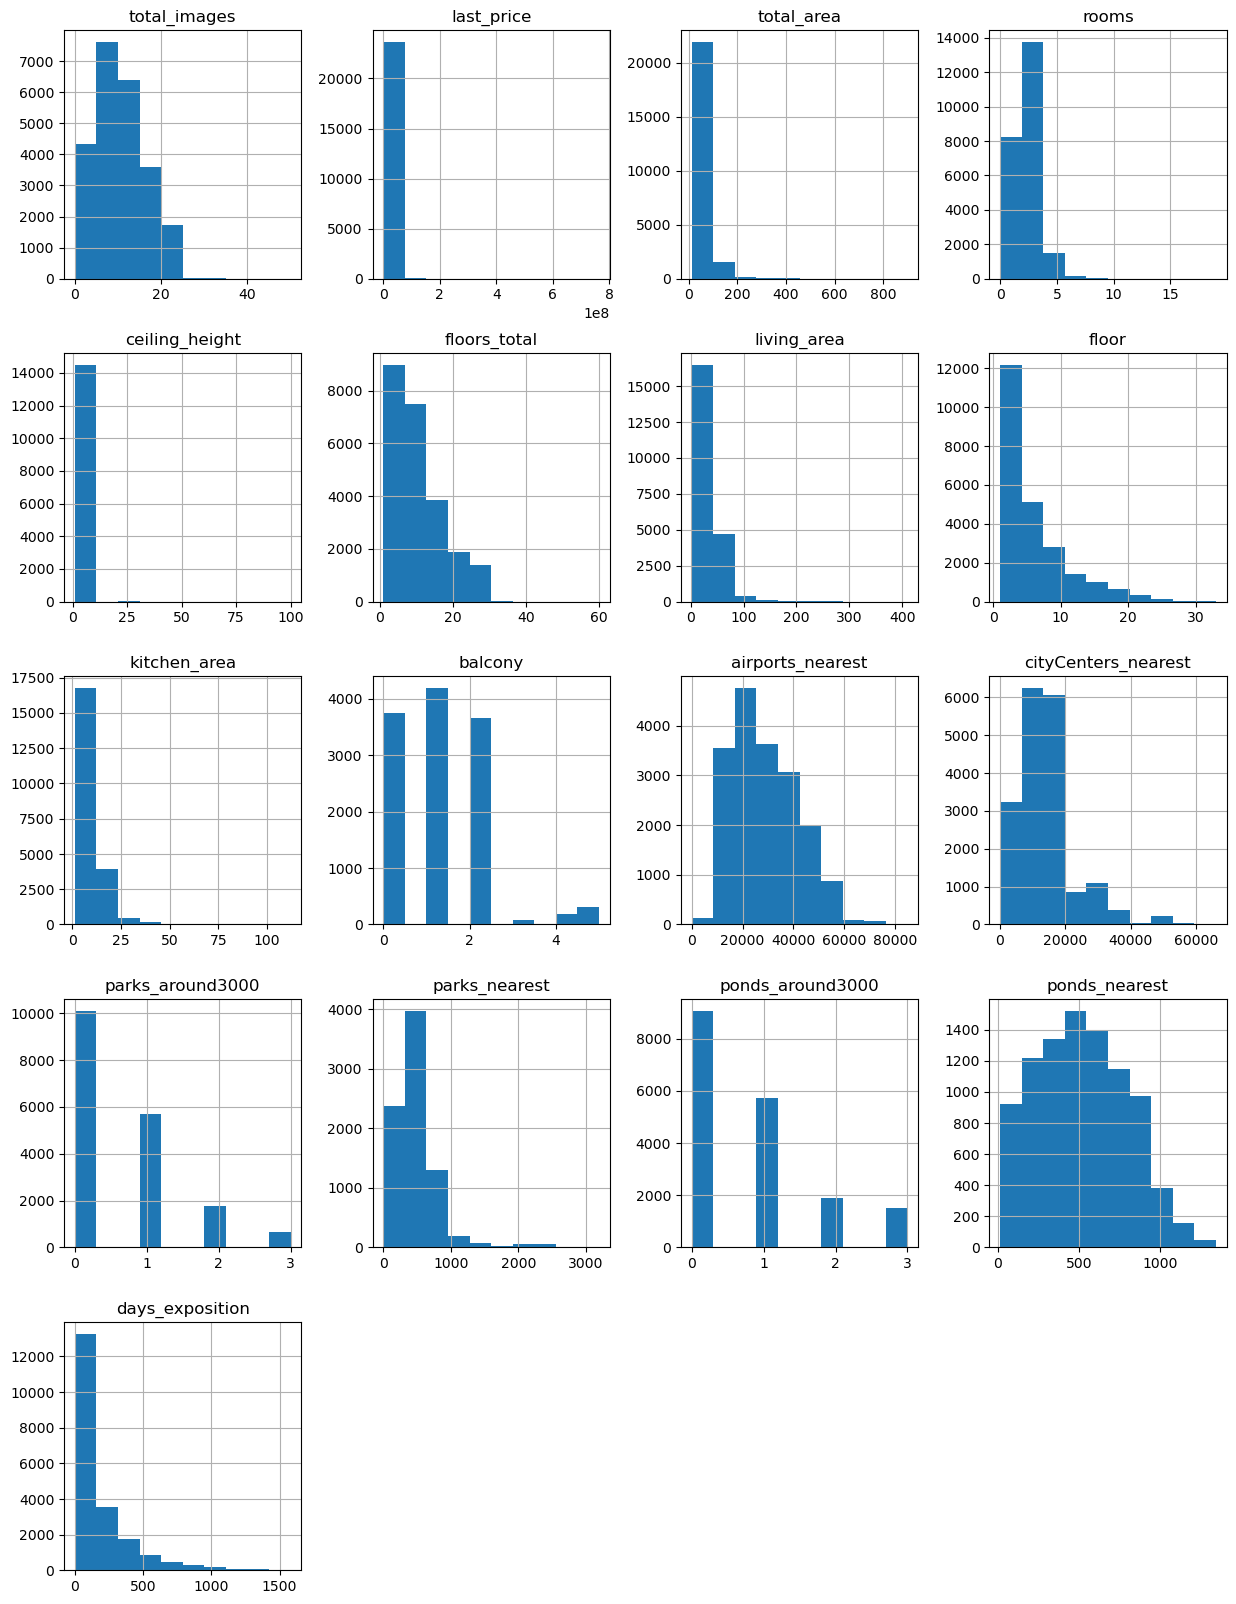

In [4]:
# построим гистограммы распределения для всех числовых столбцов
df.hist(figsize=(15, 20))
plt.show()

Изучив информацию о полученном датафрейме, можно сделать первые выводы:

- Типы данных по некоторым полям не соответствуют логике их содержания. Необходимо установить корректные типы данных.
- Заметно, что по некоторым полям количество ненулевых значений сильно ниже общего количества строк - требуется обработка пропусков.
- Распределение данных в полях last_price, total_area, living_area, kitchen_area, rooms и ceiling_height говорит о большом количестве выбросов.
- В поле ceiling_height распеределение значений вызывает сомнения в достоверности данных.

### Выполните предобработку данных

In [5]:
# приведем названия полей к змеиному регистру
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

#### Проверим данные на наличие пропусков и обработаем их

In [6]:
# посчитаем количество пропусков в каждом столбце
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
# выведем количество пропусков в каждом столбце в процентах от общего числа строк
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Сделаем предположения о природе пропусков для каждого поля:
- в поле **ceiling_height** пропуски, вероятно, связаны с незнанием высоты потолков пользователем, заполнявшим данные
- в поле **floors_total** предположим, что число этажей не проставлено для одноэтажных домов
- в поле **living_area** причина, скорее всего, в незнании пользователем точной площади
- в поле **is_apartment**, вероятно, пропущены значения False
- в поле **kitchen_area** пропуски могут быть той же природы, что и в living_area. Однако, есть вероятность что значения пропущены для помещений без кухни
- в поле **balcony** предположим, что пропущены значения 0 для помещений без балкона
- объяснить пропуски в поле **locality_name** трудно. Возможно, имело место невнимательность при заполнении
- поля **airports_nearest, city_centers_nearest, parks_around3000, ponds_around3000** получены автоматически на основе картографических данных. Учитывая большое количество пропущенных значений, можно предположить, что пропуски связаны с техническими проблемами
- в полях **ponds_nearest** и **parks_nearest** значения пропущены, вероятно, во всех строках где пропущены значения **parks_around3000** и **ponds_around3000**, а также в строках где данные значения равны нулю.
- в поле **days_exposition** содержится количество дней от публикации до снятия объявления о продаже. Можно было бы предположить, что пропущенные значения означают, что объявление не снято. Однако отстутствие пропусков в поле last_price(цена на момент снятия с публикации) опровергает эту гипотезу. Предположим, что значения пропущены при продаже объекта в день публикации объявления

In [8]:
# заполним пропуски в поле ceiling_height медианным значением
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

In [9]:
# Проверим, находятся ли все объеты с пропусками в поле floors_total в одноэтажных домах
df[df['floors_total'].isna()]['floor'].value_counts()

floor
4     10
6      9
8      8
12     6
9      5
21     4
5      4
7      4
3      4
19     3
11     3
13     3
1      3
18     3
15     3
10     3
24     2
2      2
20     2
14     2
22     1
17     1
23     1
Name: count, dtype: int64

Гипотеза о том, что все объеты с пропусками в поле floors_total находятся в одноэтажных домах **не подтвердилась**. Значит - установить этажность дома не получится. Учитавая небольшое количество пропусков в данном поле, можно удалить соответствующие строки

In [10]:
df = df.dropna(subset=['floors_total'])

В поле is_apartment предположим, что пропущены значения False

In [11]:
# заполним пропуски в поле is_apartment значением False
df['is_apartment'] = df['is_apartment'].fillna(False)

C:\Users\Алексей\AppData\Local\Temp\ipykernel_5692\1744463677.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_apartment'] = df['is_apartment'].fillna(False)


Для заполнения пропусков в поле kitchen_area найдем медианное соотношение площади кухни к общей площади

In [12]:
kitchen_area_ratio = (df['kitchen_area'] / df['total_area']).median()
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area'] * kitchen_area_ratio)

В поле balcony пропущенные значения примем за отсутствие балконов

In [13]:
# заполним пропуски в поле balcony значением 0
df['balcony'] = df['balcony'].fillna(0)

Пропуски в поле locality_name для целей исследования не несут большой важности. Проигнорируем пропущенные значения

In [14]:
# проверим, что пропуски в полях с автоматическим заполнением приходятся на одни и те же строки
df[(df['airports_nearest'].isna()) & 
   (df['city_centers_nearest'].isna()) & 
   (df['parks_around3000'].isna()) & 
   (df['ponds_around3000'].isna())].isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area              617
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              8
airports_nearest        5508
city_centers_nearest    5508
parks_around3000        5508
parks_nearest           5508
ponds_around3000        5508
ponds_nearest           5508
days_exposition          864
dtype: int64

In [15]:
df[(df['ponds_around3000'] == 0) & (df['ponds_nearest'].isna())]['ponds_around3000'].count()

9044

In [16]:
df[(df['parks_around3000'] == 0) & (df['parks_nearest'].isna())]['parks_around3000'].count()

10060

Во всех полях, полученых атоматически из геосервисов, пропущены значения в одних и тех же строках, что подтверждает гипотезу о технических проблемах при получении данных. Для решения этой проблемы необходимо запросить выгрузку данных повторно. В полях **ponds_nearest** и **parks_nearest** также пропущены значения в строках, где значения **ponds_around3000** и **parks_around3000** равны 0.

В полях **parks_around3000** и **ponds_around3000** заполним пропуски значением 0 (т.е. предположим что таких объектов в пределах 3 км нет).
В полях  **airports_nearest, city_centers_nearest, ponds_nearest** и **parks_nearest** оставим пропуски без изменений.

In [17]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['days_exposition'] = df['days_exposition'].fillna(0)

**Таким образом, можно сделать выводы по обработке пропусков в данных:**
- в поле ceiling_height пропуски заполнены медианными значениями;
- из за небольшого количества пропусков в поле floors_total, строки с данными пропусками были удалены;
- в поле is_apartment пропуски заполнены значениями False;
- пропуски в поле kitchen_area заполнены по медианной доле площади кухни от общей площади;
- в поле balcony пропуски заполнены значение 0;
- пропуски в поле locality_name были проигнорированы, так как не влияют на выполнение исследования;
- в полях living_area, airports_nearest, cityCenters_nearest, ponds_nearest и parks_nearest пропуски также были проигнорированы;
- в полях parks_around3000, ponds_around3000, а также days_exposition пропуски заполнены значением 0.

In [18]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1870
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              48
airports_nearest         5532
city_centers_nearest     5509
parks_around3000            0
parks_nearest           15568
ponds_around3000            0
ponds_nearest           14552
days_exposition             0
dtype: int64

#### Установим корректные типы данных для всех полей

- поле first_day_exposition приведем к типу datetime для работы с датами;
- поле is_apartment приведем к булеву типу для возможности правильной фильтрации по нему;
- все количественные поля приведем к целочисленному типу, т.к. количество не может быть дробным числом

In [19]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['floors_total'] = df['floors_total'].astype('int')
df['is_apartment'] = df['is_apartment'].astype('bool')
df['balcony'] = df['balcony'].astype('int')
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].astype('int')
df['days_exposition'] = df['days_exposition'].astype('int')
df.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest               float64
city_centers_nearest           float64
parks_around3000                 int32
parks_nearest                  float64
ponds_around3000                 int32
ponds_nearest                  float64
days_exposition                  int32
dtype: object

#### Проверим данные на наличие явных и неявных дубликатов

In [20]:
df.duplicated().sum()

0

Явных дубликов в данных нет. Проверим на неявные дубликаты поле **locality_name**

In [21]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Названия населенных пунктов написаны в разном стиле - где-то указан тип населенного пункта, где-то только название, что может вести к наличию дубликатов. Созданим и применим функцию для очистки названий от дополнительных слов.

In [22]:
def locality_names_hander(name):
    remove_parts = ['поселок', 'городской', 'деревня', 'городского типа', 
                    'садовое товарищество', 'село', 'садоводческое некоммерческое товарищество',
                    'при железнодорожной', 'станции', 'коттеджный']
    if not isinstance(name, float):
        n = name.replace("ё", "е")
        for part in remove_parts:
            n = n.replace(part, '')
        n = n.strip()
        return n
    return name

После обработки дубликатов в поле locality_name не выявлено

На этапе предобработки данных был обработан ряд проблем с исходным датасетом. 

В данных имеется большое количество пропущенных значений, что может оказать негативное влияние на качество исследования. По некоторым полям пропуски были заполнены в соответствии с логикой данных. Там, где логичную замену предложить невозможно, пропуски были оставлены без изменений. Для более качественных результатов, рекомендуется запросить повторно выгрузку автоматических данных из геосервисов.

Название населённых пунктов в датасете содержали множество дополнительных слов (поселок, село, садовое товарищество и т.д.), что приводило к разному обозначению одних и тех же населенных пунктов и потенциальным ошибкам при агрегировании данных. Рекомендуется в дальнейшем указывать названия населённых пунктов в чистом виде, а, при необходимости, указывать тип населенного пункта в отдельном поле.

### Добавьте в таблицу новые столбцы

Добавим в таблицу столбцы:
- **price_1m2:** цена 1 кв метра
- **weekday_exposition:** день недели публикации объявления
- **month_exposition:** месяц публикации объявления
- **year_exposition:** год публикации объявления
- **floor_type:** тип этажа квартиры (значения — «первый», «последний», «другой»)
- **city_centers_nearest_km:** расстояние до центра города в километрах

Для определения типа этажа квартиры создадим функцию *floor_type*

In [24]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [25]:
df['price_1m2'] = round(df['last_price'] / df['total_area'], 2)
df['weekday_exposition'] = df['first_day_exposition'].dt.dayofweek
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year
df['floor_type'] = df.apply(floor_type, axis=1)
df['city_centers_nearest_km'] = (df['city_centers_nearest'] / 1000).round()

In [26]:
# проверим корректность работы функции floor_type
df['floor_type'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

### Проведите исследовательский анализ данных

Исследуем основные параметры объектов недвижимости. Посмотрим на распределения значений и возможные выбросы, построив гистограммы для каждого параметра

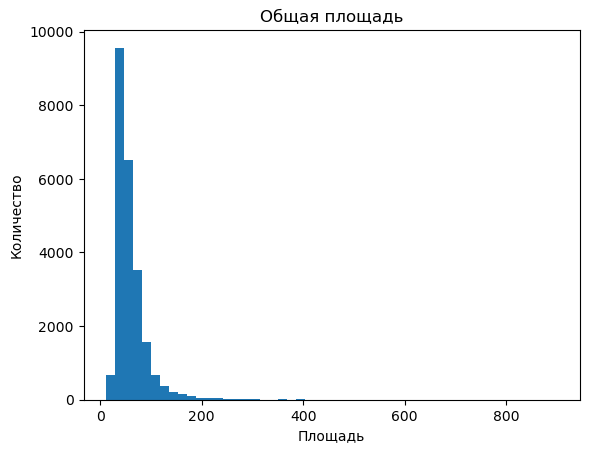

In [27]:
plt.hist(x=df['total_area'], bins=50)
plt.title('Общая площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

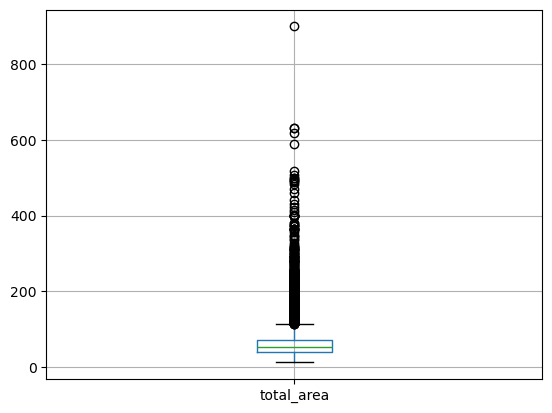

In [28]:
df.boxplot('total_area')
df['total_area'].describe()

Подавляющая доля объектов имеет общую площадь в пределах от 30 до 200 кв метров. Однако, достаточно много значений находится в диапазоне до 400 кв метров. После встречаются лишь отдельные выбросы. Отфильтруем их и посмотрим на распределение более детально

In [29]:
df = df[df['total_area'] <= 400]

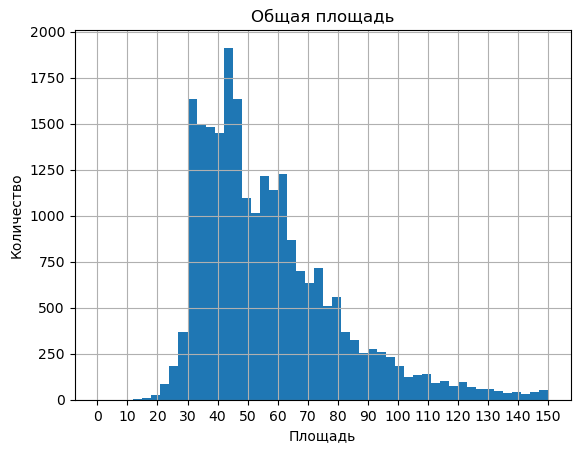

In [30]:
plt.hist(x=df['total_area'], bins=50, range=(0, 150))
plt.title('Общая площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.xticks(ticks=range(0, 151, 10))
plt.grid(True)
plt.show()

Заметны выделяющиеся пики распределения при значения площади около 30, 45 и 60 кв метров, что может говорить о наличии типовых размеров квартир

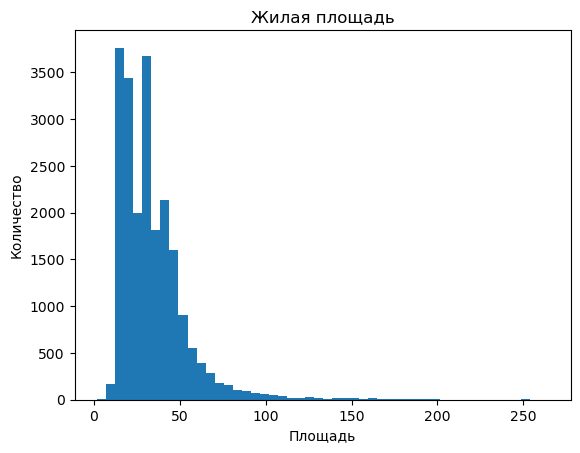

In [31]:
plt.hist(x=df['living_area'], bins=50)
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

count    21726.000000
mean        34.272174
std         20.849484
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        264.500000
Name: living_area, dtype: float64

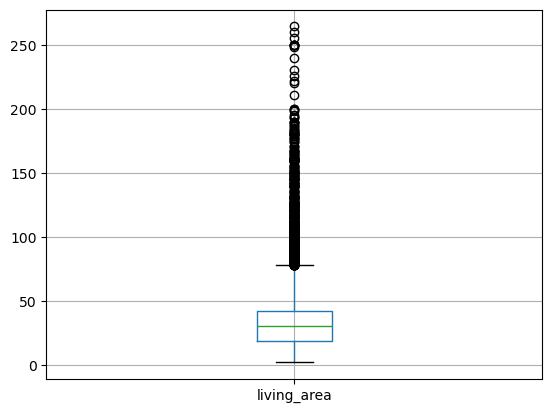

In [32]:
df.boxplot('living_area')
df['living_area'].describe()

Основная масса объектов имеет жилую площадь от 10 до 100 кв метров. Достаточно много значений находится в диапазоне до 250 кв метров. Посмотрим на распределение в диапазоне до 100 кв метров.

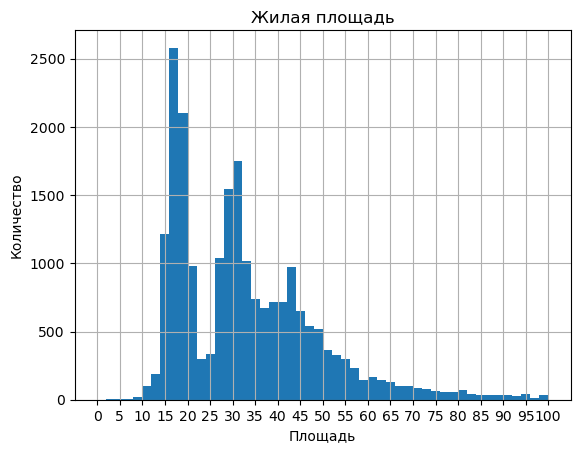

In [33]:
plt.hist(x=df['living_area'], bins=50, range=(0, 100))
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.xticks(ticks=range(0, 101, 5))
plt.grid(True)
plt.show()

При более детальном рассмотрении заметно, что наиболее распространены квартиры с жилой площадью от 15 до 20 м2, от 25 до 35 м2 и от 40 до 45 м2. Можно предположить, что пики приходятся на квартиры с разным количеством комнат. Проверим эту гипотезу

In [34]:
df.pivot_table(index='rooms', values='living_area', aggfunc=['count','median'])

,count,median
,living_area,living_area
rooms,,
0,183,18.00
1,7368,17.60
2,7279,30.50
3,5353,45.00
4,1086,63.50
5,288,91.45
6,95,123.60
7,46,142.50


Медианные значения жилой площади для 1- 2- и 3-комнатных квартир совпадает с пиками распределения жилой площади

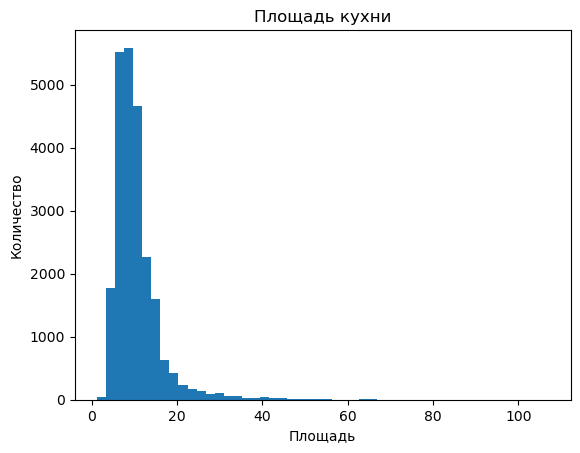

In [35]:
plt.hist(x=df['kitchen_area'], bins=50)
plt.title('Площадь кухни')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.show()

count    23590.000000
mean        10.450205
std          5.847560
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

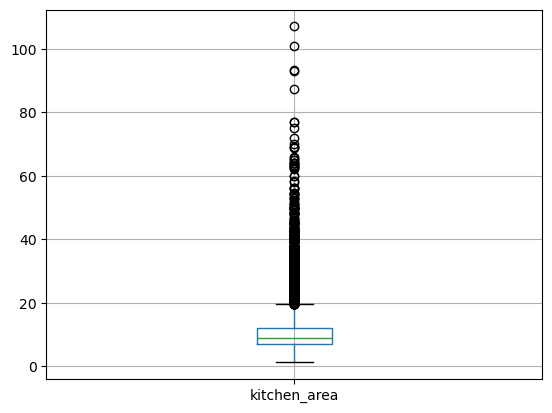

In [36]:
df.boxplot('kitchen_area')
df['kitchen_area'].describe()

Основная масса объектов имеет площадь кухни от 5 до 20 кв метров. Достаточно много значений находится в диапазоне до 60 кв метров. Отфильтруем строки со значением kitchen_area более 60. Посмотрим на распределение более детально

In [37]:
df = df[df['kitchen_area'] <= 60]

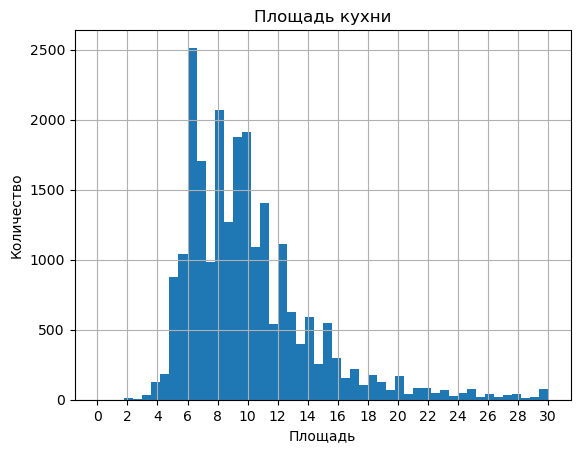

In [38]:
plt.hist(x=df['kitchen_area'], bins=50, range=(0, 30))
plt.title('Площадь кухни')
plt.xlabel('Площадь')
plt.ylabel('Количество')
plt.xticks(ticks=range(0, 31, 2))
plt.grid(True)
plt.show()

Наиболее распространеные размеры кухни в представленых данных: 
- 6 м2
- 8 м2
- 10 м2

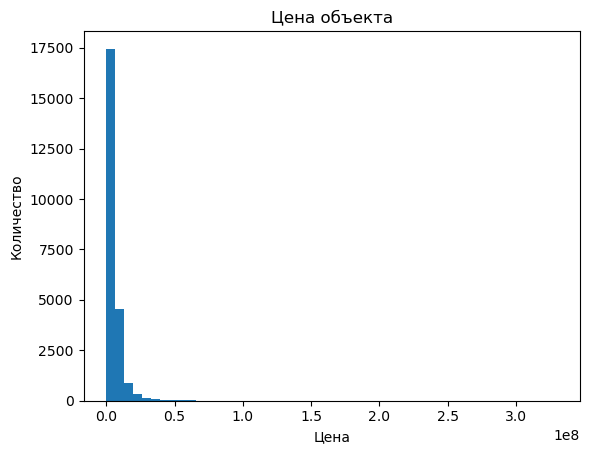

In [39]:
plt.hist(x=df['last_price'], bins=50)
plt.title('Цена объекта')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

count    2.356200e+04
mean     6.324572e+06
std      7.891333e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.615000e+06
75%      6.750000e+06
max      3.300000e+08
Name: last_price, dtype: float64

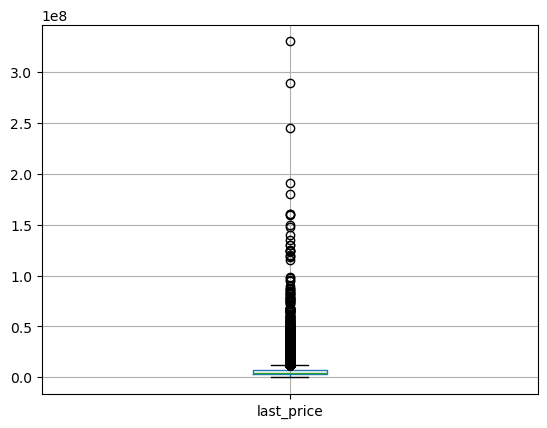

In [40]:
df.boxplot('last_price')
df['last_price'].describe()

Основная часть объектов имеет цену до 50 млн. Цены выше примем за выбросы и отфильтруем. Изучим подробнее диапазон до 20 млн

In [41]:
df = df[df['last_price'] <= 50_000_000]

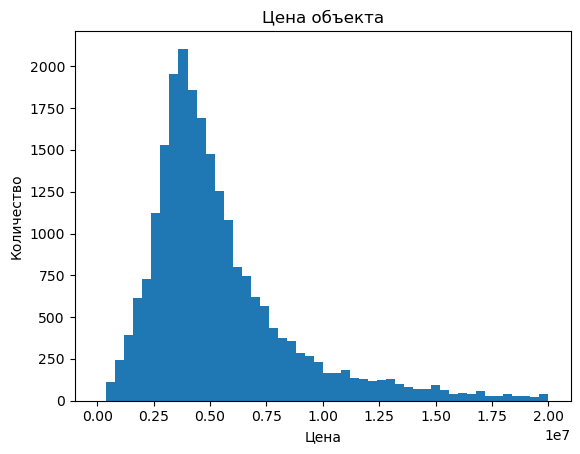

In [42]:
plt.hist(x=df['last_price'], bins=50, range=(0, 20_000_000))
plt.title('Цена объекта')
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.show()

Значитильная часть квартир имеет стоимость от 2.5 до 7 млн

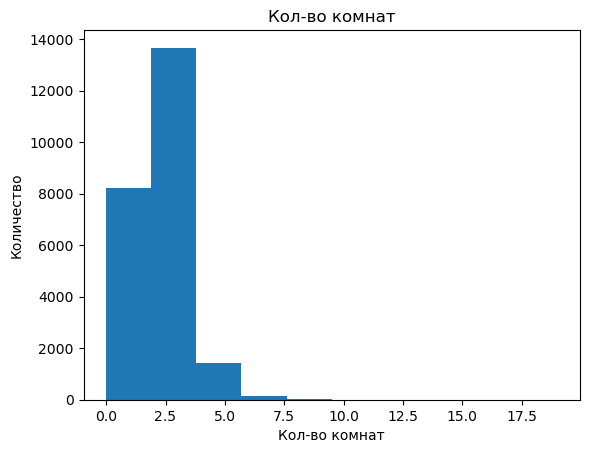

In [43]:
plt.hist(x=df['rooms'], bins=10)
plt.title('Кол-во комнат')
plt.xlabel('Кол-во комнат')
plt.ylabel('Количество')
plt.show()

count    23463.000000
mean         2.055023
std          1.052050
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

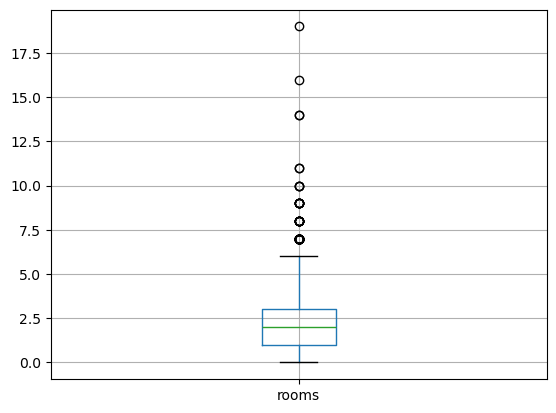

In [44]:
df.boxplot('rooms')
df['rooms'].describe()

Примем за выбросы объекты с количеством комнат выше 6

In [45]:
df = df[df['rooms'] <= 6]

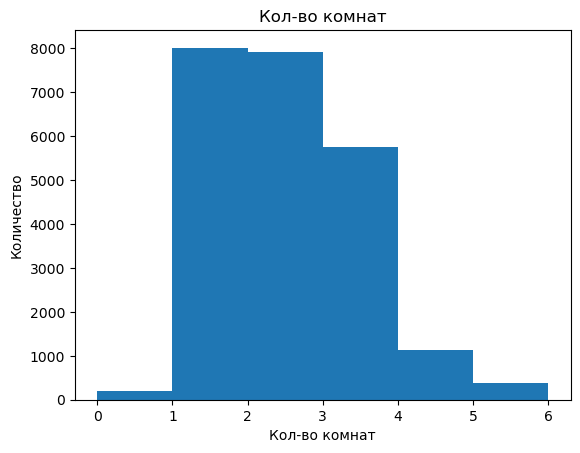

In [46]:
plt.hist(x=df['rooms'], bins=6)
plt.title('Кол-во комнат')
plt.xlabel('Кол-во комнат')
plt.ylabel('Количество')
plt.show()

Большество квартир имеет 1, 2 или 3 комнаты

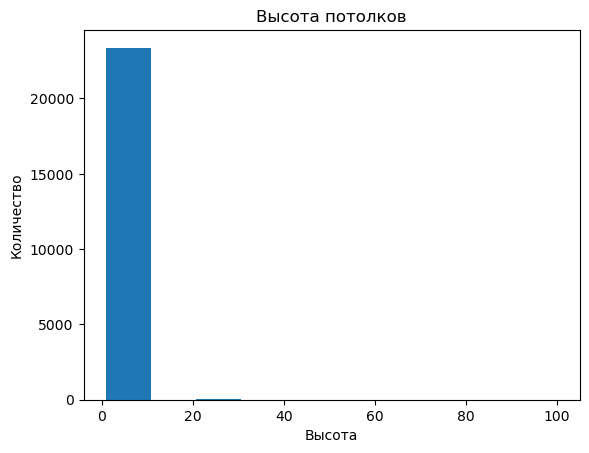

In [47]:
plt.hist(x=df['ceiling_height'], bins=10)
plt.title('Высота потолков')
plt.xlabel('Высота')
plt.ylabel('Количество')
plt.show()

count    23395.000000
mean         2.720415
std          0.992224
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

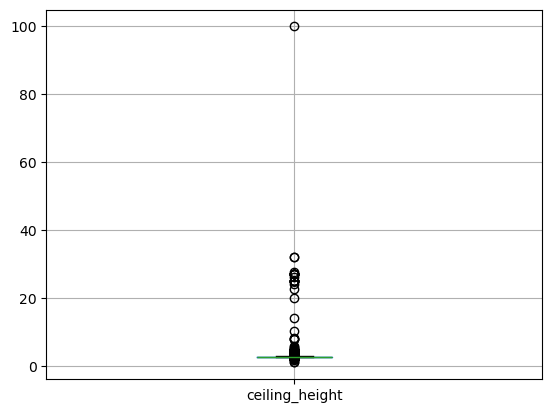

In [48]:
df.boxplot('ceiling_height')
df['ceiling_height'].describe()

В поле ceiling_height имеются значительные выбросы. Существование объектов с высотой пололка выше 5 метров кажется маловероятным. Можно предположить, что в значених от 20 метров была допущена ошибка с разрядностью числа. Разделим такие значения на 10. Значения от 5 до 20 отфильтруем. Также отфильтруем как маловероятные значение высоты пололка ниже 2 метров

In [49]:
def ceiling_height_limit(h):
    if h >= 20:
        return h / 10
    return h

In [50]:
df['ceiling_height'] = df['ceiling_height'].apply(ceiling_height_limit)
df = df[(df['ceiling_height'] >= 2) & (df['ceiling_height'] <= 5)]

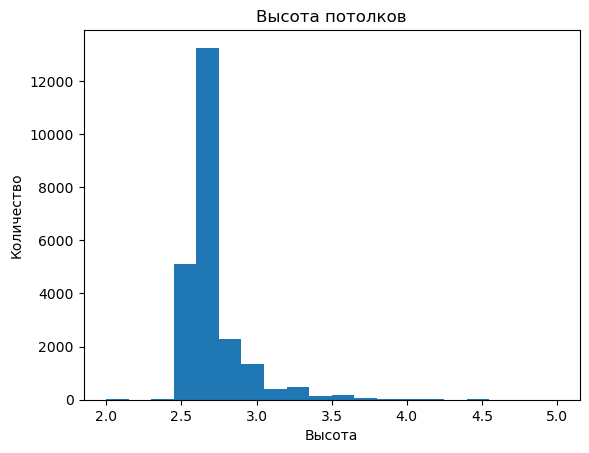

In [51]:
plt.hist(x=df['ceiling_height'], bins=20)
plt.title('Высота потолков')
plt.xlabel('Высота')
plt.ylabel('Количество')
plt.show()

Абсолютное большинство квартир в выборке имеет высоту потолков от 2.5 до 2.8 метров. Также выделяется группа квартир с высотой потолков около 3.1 метра

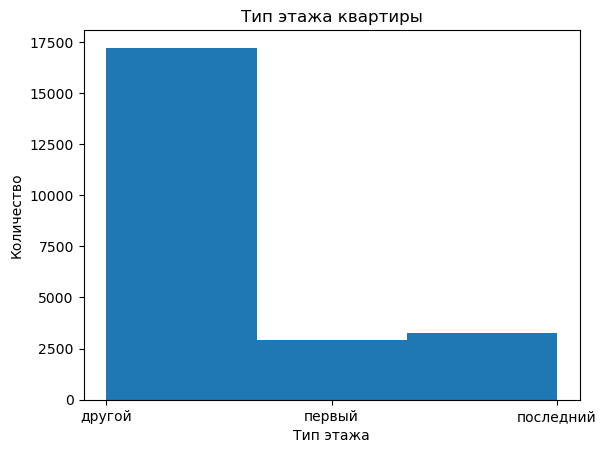

In [52]:
plt.hist(x=df['floor_type'], bins=3)
plt.title('Тип этажа квартиры')
plt.xlabel('Тип этажа')
plt.ylabel('Количество')
plt.show()

Менее трети объектов расположены на первом либо последнем этажах

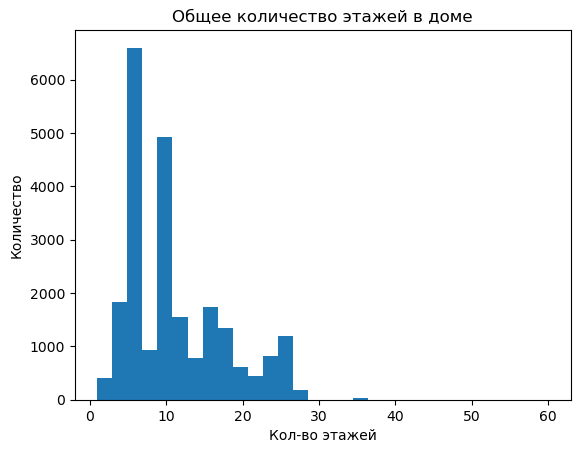

In [53]:
plt.hist(x=df['floors_total'], bins=30)
plt.title('Общее количество этажей в доме')
plt.xlabel('Кол-во этажей')
plt.ylabel('Количество')
plt.show()

count    23382.000000
mean        10.712215
std          6.606801
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

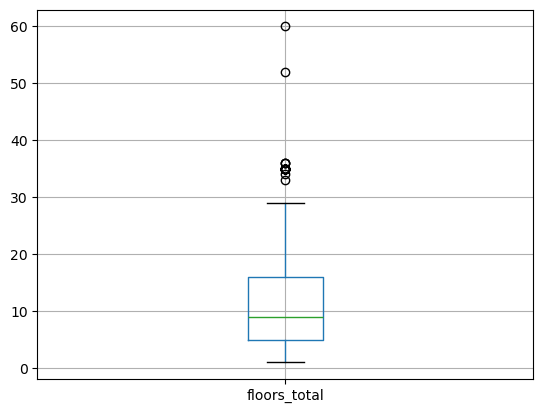

In [54]:
df.boxplot('floors_total')
df['floors_total'].describe()

Основная доля объектов расположена до 30 этажа. Значения выше отфильтруем

In [55]:
df = df[df['floors_total'] <= 30]

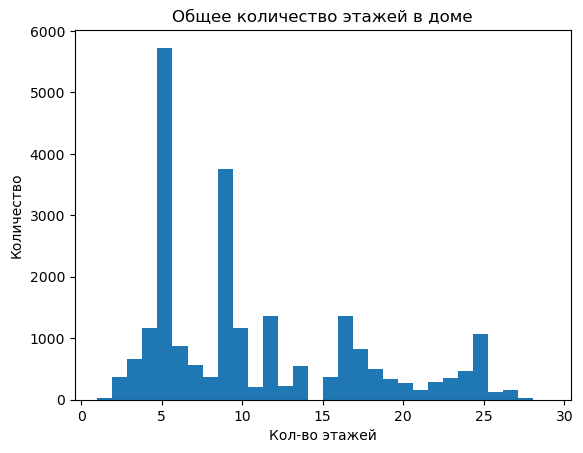

In [56]:
plt.hist(x=df['floors_total'], bins=30)
plt.title('Общее количество этажей в доме')
plt.xlabel('Кол-во этажей')
plt.ylabel('Количество')
plt.show()

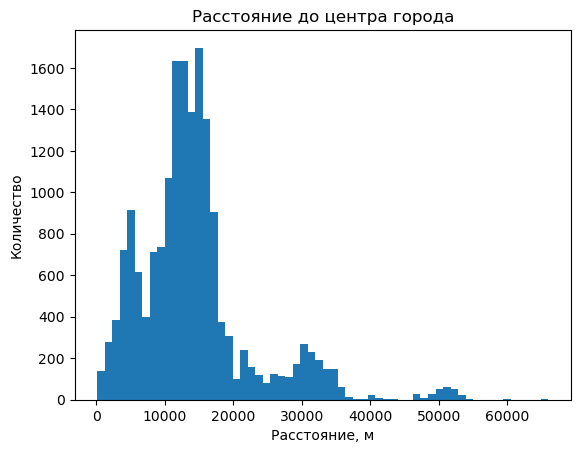

In [57]:
plt.hist(x=df['city_centers_nearest'], bins=60)
plt.title('Расстояние до центра города')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество')
plt.show()

count    17848.000000
mean     14276.483135
std       8597.401772
min        181.000000
25%       9425.000000
50%      13149.000000
75%      16298.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

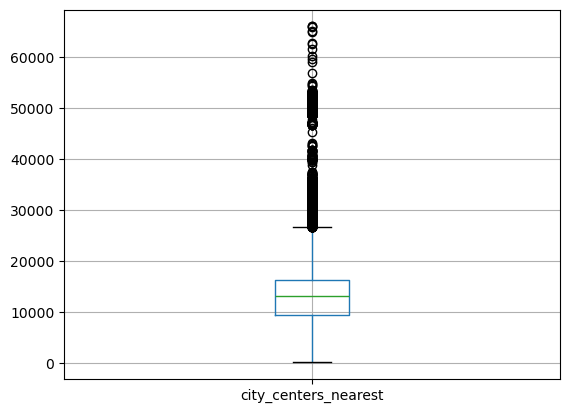

In [58]:
df.boxplot('city_centers_nearest')
df['city_centers_nearest'].describe()

Основная масса объектов расположена в пределах 20 км от центра города. Имеются необычные пики распределения при значениях около 30 км и около 50 км. Можно предположить, что здесь также допущена ошибка в разрядности чисел, однако такое допущение может значительно повлиять на результаты исследования. Оставим поле без фильтрации выбросов

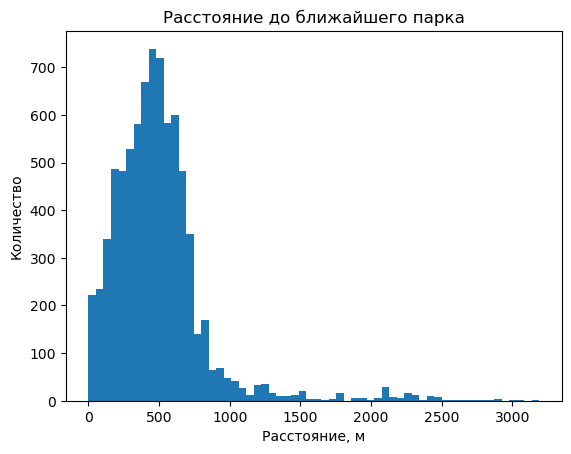

In [59]:
plt.hist(x=df['parks_nearest'], bins=60)
plt.title('Расстояние до ближайшего парка')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество')
plt.show()

count    7873.000000
mean      492.075956
std       342.033767
min         1.000000
25%       288.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

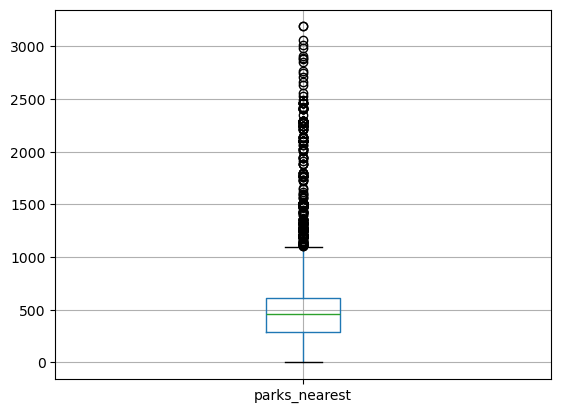

In [60]:
df.boxplot('parks_nearest')
df['parks_nearest'].describe()

В имеющейся выборке большая часть квартир расположена в пределах 1.5 км от ближайшего парка

#### Изучим, как быстро продавались квартиры, проанализировав поле days_exposition

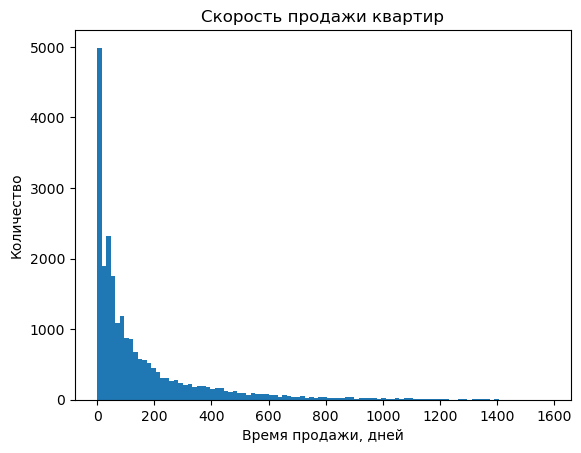

In [61]:
plt.hist(x=df['days_exposition'], bins=100)
plt.title('Скорость продажи квартир')
plt.xlabel('Время продажи, дней')
plt.ylabel('Количество')
plt.show()

count    23351.000000
mean       155.924885
std        212.794487
min          0.000000
25%         23.000000
50%         73.000000
75%        197.000000
max       1580.000000
Name: days_exposition, dtype: float64

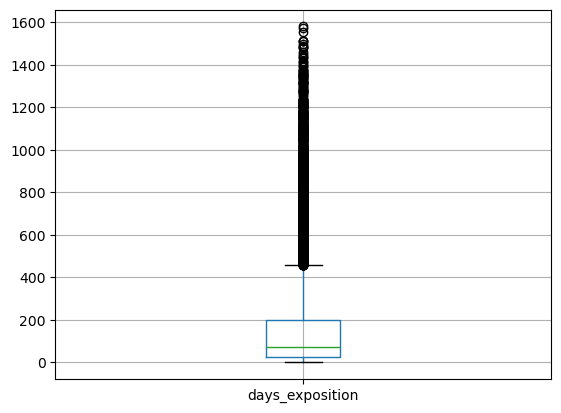

In [62]:
df.boxplot('days_exposition')
df['days_exposition'].describe()

Продажа квартир, как правило, занимает до 500 дней. Среднее значение времени продажи составило 156 дней, медианное значение - 73 дня. Условно быстрыми продажами назовем продажи, занявшие не более 23 дня (1 квартиль), условно долгими - продажи, занявшие более 197 дней (3 квартиль)

#### Определим факторы, которые больше всего влияют на стоимость объекта.

Определим как на цену влияют общая площадь, площадь кухни, жилая площадь и количество комнат

In [63]:
df[['total_area', 'living_area', 'kitchen_area', 'rooms', 'last_price']].corr()

,total_area,living_area,kitchen_area,rooms,last_price
total_area,1.000000,0.927697,0.621001,0.777596,0.776652
living_area,0.927697,1.000000,0.379804,0.863881,0.674519
kitchen_area,0.621001,0.379804,1.000000,0.276818,0.618318
rooms,0.777596,0.863881,0.276818,1.000000,0.483389
last_price,0.776652,0.674519,0.618318,0.483389,1.000000


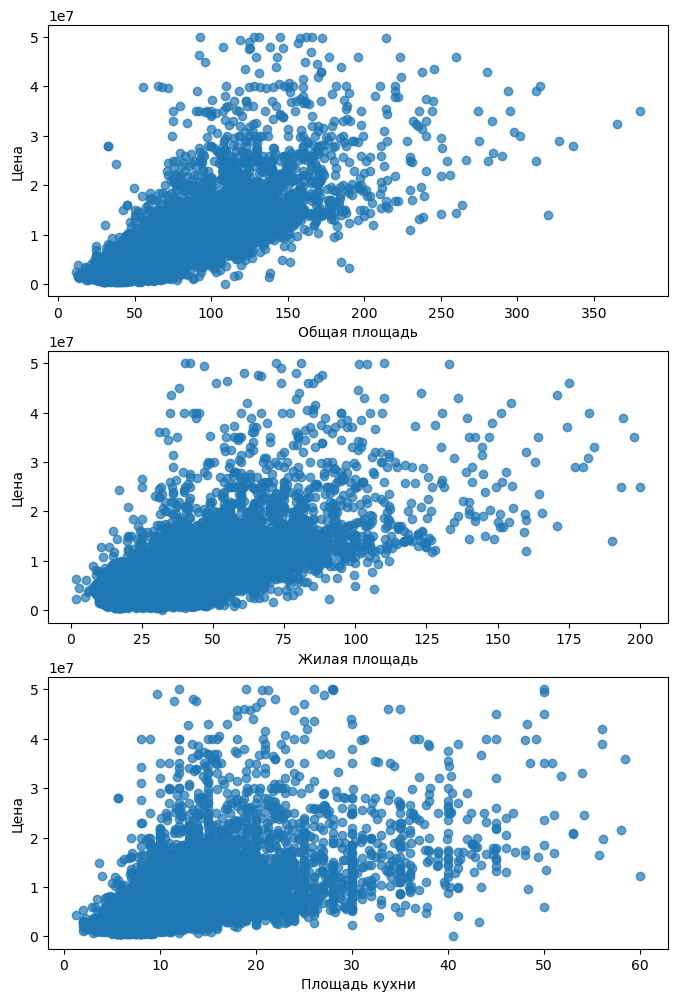

In [64]:
#d.plotting.scatter_matrix(df[['total_area', 'living_area', 'kitchen_area', 'rooms', 'last_price']]
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].scatter(x=df['total_area'], y=df['last_price'], alpha=0.7)
ax[0].set_xlabel('Общая площадь')
ax[0].set_ylabel('Цена')
ax[1].scatter(x=df['living_area'], y=df['last_price'], alpha=0.7)
ax[1].set_xlabel('Жилая площадь')
ax[1].set_ylabel('Цена')
ax[2].scatter(x=df['kitchen_area'], y=df['last_price'], alpha=0.7)
ax[2].set_xlabel('Площадь кухни')
ax[2].set_ylabel('Цена')
plt.show()

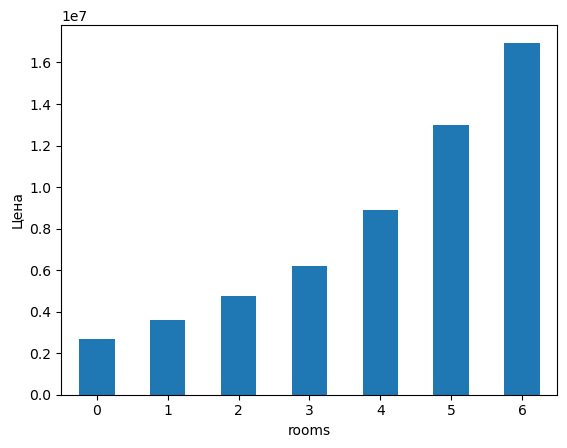

In [65]:
# построим график медианной стоимости для объектов с разным количеством комнат
df.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(kind='bar', 
                                                                          ylabel='Цена', 
                                                                          legend=False)
plt.xticks(rotation=0)
plt.show()

- Общая площадь имеет выраженную корреляцию с общей стоимостью и, вероятно, оказывает на нее значимое влияние.
- Жилая площадь имеет чуть менее выраженную, но все же значимую корреляцию и также оказывает влияние на цену.
- Влияние на стоимоть площади кухни ниже, однако положительная корреляция также прослеживается.
- Медианная стоимость квартиры значимо растет при увеличении числа комнат

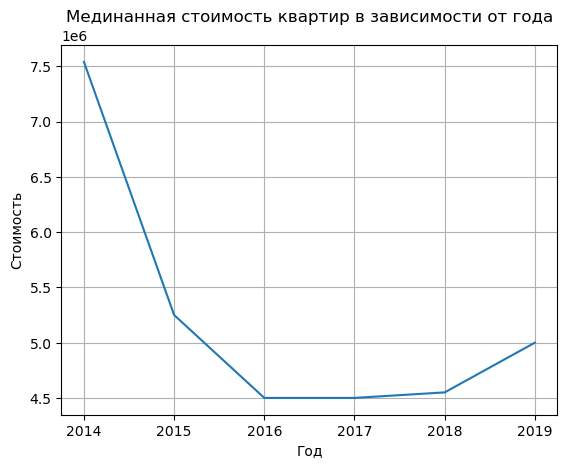

In [66]:
# построим график медианной стоимости квартир по годам
(df.pivot_table(index='year_exposition', values='last_price', aggfunc='median')
   .plot(kind='line', ylabel='Стоимость', legend=False))
plt.title('Мединанная стоимость квартир в зависимости от года')
plt.xlabel('Год')
plt.grid(True)
plt.show()

В 2014 году наблюдается выраженный пик стоимости квартир. Проверим не связан ли он с некорректной выборкой по данному году

,last_price
year_exposition,
2014,134
2015,1156
2016,2730
2017,8060
2018,8434
2019,2837


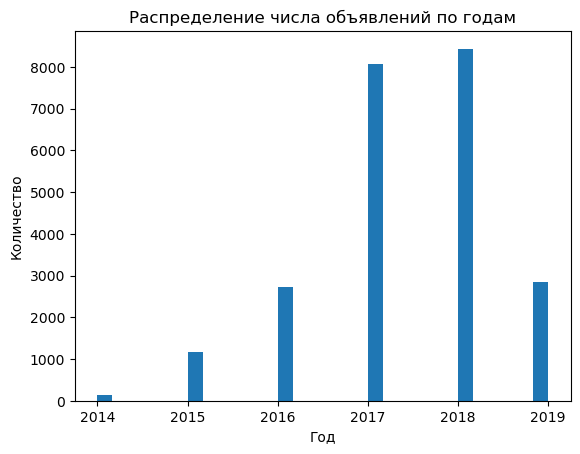

In [67]:
plt.hist(x=df['year_exposition'], bins=30)
plt.xlabel('Год')
plt.ylabel('Количество')
plt.title('Распределение числа объявлений по годам')
plt.xlabel('Год')
df.pivot_table(index='year_exposition', values='last_price', aggfunc='count')

В 2014 году количество объявлений было сильно ниже чем в последующие годы, что сильно искажает результаты. Отфильтруем годы с количеством объявлений меньше 200

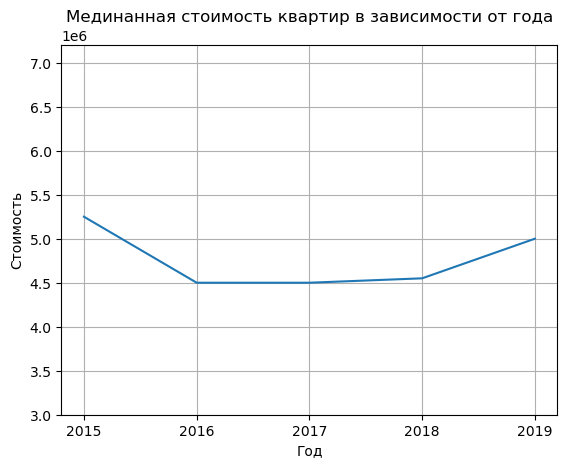

In [68]:
df_years = df.pivot_table(index='year_exposition', values='last_price', aggfunc=['count', 'median'])
df_years.columns = ['count', 'median_price']
df_years.query('count >= 200')['median_price'].plot(kind='line', 
                                                    ylabel='Стоимость',
                                                    legend=False, 
                                                    ylim=(3_000_000, 7_200_000))
plt.title('Мединанная стоимость квартир в зависимости от года')
plt.xlabel('Год')
plt.xticks(ticks=df_years.query('count >= 200').index)
plt.grid(True)
plt.show()
   

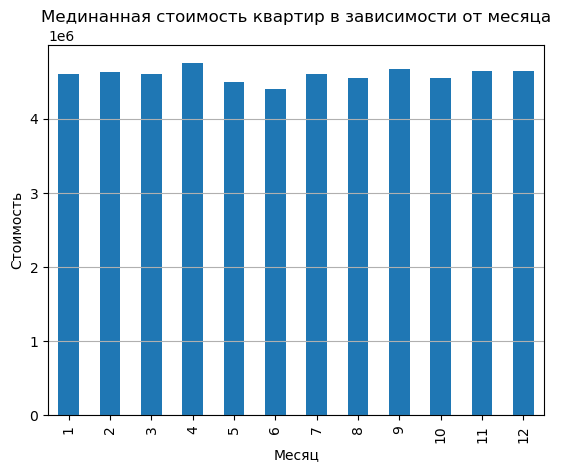

In [69]:
# построим график медианной стоимости квартир по месяцам
df.pivot_table(index='month_exposition', values='last_price', aggfunc='median').plot(kind='bar', 
                                                                                     ylabel='Стоимость', 
                                                                                     legend=False)
plt.grid(True, axis='y')
plt.title('Мединанная стоимость квартир в зависимости от месяца')
plt.xlabel('Месяц')
plt.show()

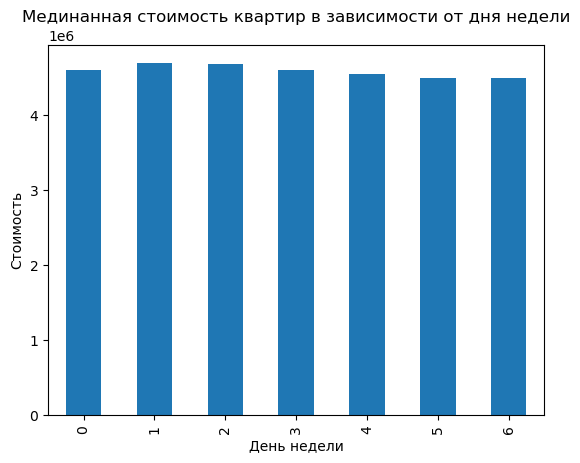

In [70]:
# построим график медианной стоимости квартир по дням недели
df.pivot_table(index='weekday_exposition', values='last_price', aggfunc='median').plot(kind='bar', 
                                                                                       ylabel='Стоимость', 
                                                                                       legend=False)
plt.title('Мединанная стоимость квартир в зависимости от дня недели')
plt.xlabel('День недели')
plt.show()

Рассмотрев зависимости стоимости квартир от даты размещения объявления можно сделать выводы:
- колебания стоимости по месяцам носят **случайный характер**;
- от дня недели в который размещено объявление стоимость также **не зависит**;
- **заметны изменения** стоимости  квартир по годам. В 2015 году наблюдался пик стоимости, после которого последовало заметное снижение. В 2017 году медианная стоимость достигла низшего значения, после чего начался небольшой рост, вплоть до конца наблюдений. Снижение медианной стоимости до 2017 года может объясняться ростом числа размещаемых объявлений и, как следствие, ростом масштаба выборки. Если учесть этот фактор и рассматривать только объявления с 2017 года, можно сделать вывод, что цена на квартиры из года в год возрастает.

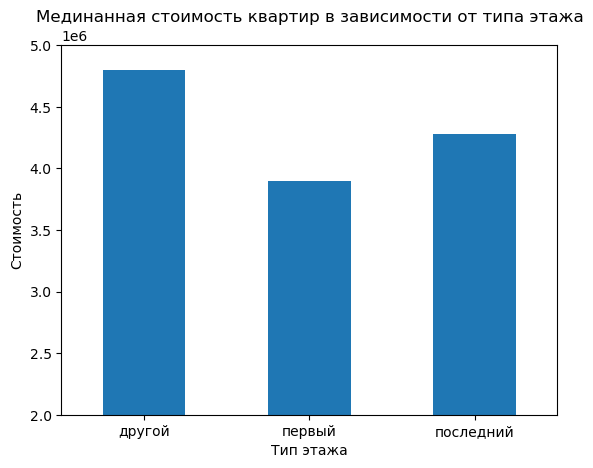

In [71]:
# построим график медианной стоимости квартир в зависимости от этажа
df.pivot_table(index='floor_type', values='last_price', aggfunc='median').plot(kind='bar', 
                                                                               ylabel='Стоимость', 
                                                                               legend=False, 
                                                                               ylim=(2_000_000, 5_000_000))
plt.title('Мединанная стоимость квартир в зависимости от типа этажа')
plt.xlabel('Тип этажа')
plt.xticks(rotation=0)
plt.show()

In [72]:
# выведем медианные значения в виде таблицы для большей детализации
df.pivot_table(index='floor_type', values='last_price', aggfunc='median')

,last_price
floor_type,
другой,4800000.0
первый,3900000.0
последний,4280000.0


Из имеющихся данных видно, что квартиры на 1 этаже оцениваются **ниже** чем на любом другом. Расположение квартиры на последнем этаже также может выступать фактором снижения стоимости, однако намного менее значимым, чем расположение на 1 этаже.

#### Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра недвижимости

In [73]:
# определим 10 населенных пунктов с наибольшим числом объявлений и посчитаем среднюю цену квадратного метра
most_common_loc = df.pivot_table(index='locality_name', values='price_1m2', aggfunc=['count', 'mean'])
most_common_loc.columns = ['count', 'mean_price_m2']
most_common_loc = most_common_loc.sort_values(by='count', ascending=False).head(10)
most_common_loc

,count,mean_price_m2
locality_name,,
Санкт-Петербург,15399,112230.109302
Мурино,586,86041.116024
Кудрово,470,95260.846128
Шушары,439,78551.344647
Всеволожск,398,68654.473970
Пушкин,365,102900.024767
Колпино,337,75333.295816
Парголово,326,90332.262638
Гатчина,307,68746.146515


In [74]:
# найдем населенный пункт с самой низкой стоимостью квадратного метра
most_common_loc[most_common_loc['mean_price_m2'] == most_common_loc['mean_price_m2'].min()]

,count,mean_price_m2
locality_name,,
Выборг,237,58141.909325


In [75]:
# найдем населенный пункт с самой высокой стоимостью квадратного метра
most_common_loc[most_common_loc['mean_price_m2'] == most_common_loc['mean_price_m2'].max()]

,count,mean_price_m2
locality_name,,
Санкт-Петербург,15399,112230.109302


Самым дорогим населенным пунктом по стоимости квадратного метра в анализируемых данных является Санкт-Петербург, ср цена квадратного метра **112 тыс**.
Самым дешевым населенным пунктом по стоимости квадратного метра в анализируемых данных является Выборг, ср цена квадратного метра **58 тыс**.

#### Определим, насколько стоимость квартир в Санкт-Петербурге зависит от расстояния до центра города 

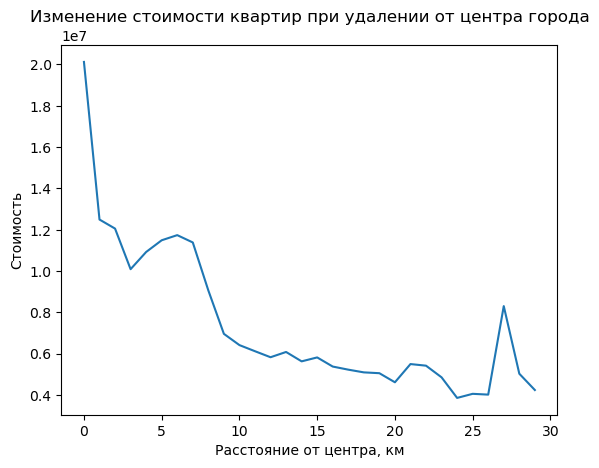

In [76]:
pererburg_loc = df.query('locality_name == "Санкт-Петербург"')
(pererburg_loc.pivot_table(index='city_centers_nearest_km', 
                           values='last_price', 
                           aggfunc='mean')
              .plot(kind='line', ylabel='Стоимость', legend=False)
)
plt.title('Изменение стоимости квартир при удалении от центра города')
plt.xlabel('Расстояние от центра, км')
plt.show()

На графике отчетливо видна зависимость между расстоянием квартир от центра города и их средней ценой: **при увеличении расстояния цена снижается**. 
Однако, наблюдаются резкие пики средней стоимости при расстоянии около 7 и около 27 км от центра. Данные пики могут быть обусловлены наличием на указанных расстояниях районов с дорогой недвижимостью. Также, можно предположить некоторые проблемы с выборкой квартир в этих группах. Проверим эту гипотезу

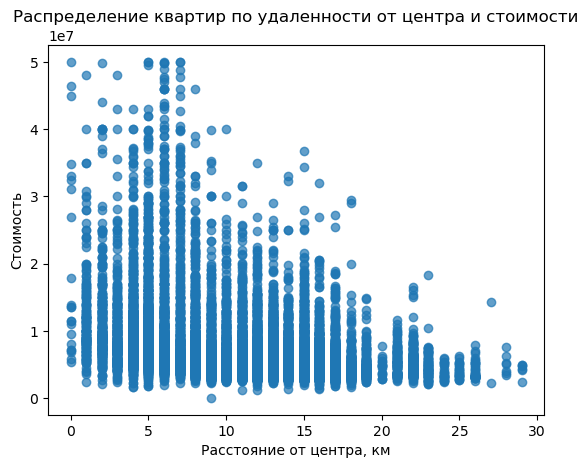

In [77]:
plt.scatter(x=pererburg_loc['city_centers_nearest_km'], y=pererburg_loc['last_price'], alpha=0.7)
plt.title('Распределение квартир по удаленности от центра и стоимости')
plt.xlabel('Расстояние от центра, км')
plt.ylabel('Стоимость')
plt.show()

На последнем графике заметно, что причиной резкого пика стоимости квартир после 25 км от центра города является малое количество квартир в данных групах. Отфильтруем группы в которых менее 10 квартир и построим график еще раз 

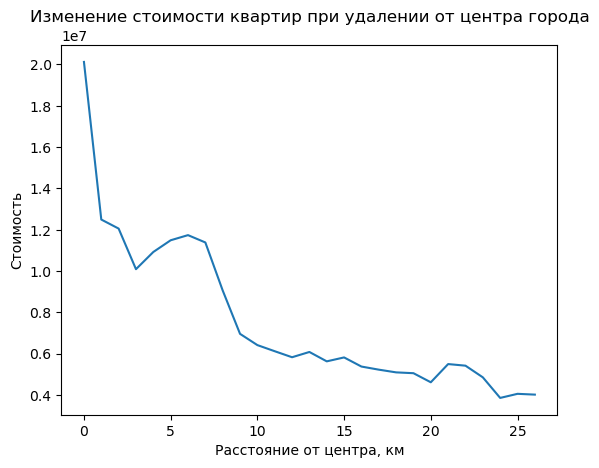

In [78]:
pererburg_loc = pererburg_loc.pivot_table(index='city_centers_nearest_km', 
                                          values='last_price', 
                                          aggfunc=['count', 'mean'])
pererburg_loc.columns = ['count', 'mean_price']
pererburg_loc = pererburg_loc.query('count >= 10')
pererburg_loc['mean_price'].plot(kind='line', ylabel='Стоимость', legend=False)
plt.title('Изменение стоимости квартир при удалении от центра города')
plt.xlabel('Расстояние от центра, км')
plt.show()

График на основе очищенных данных показывает устойчивую тенденцию к снижению стоимости квартир с удалением от центра, за исключением пика на расстоянии 7 км

### Напишите общий вывод

В рамках данного исследования были проанализированы данные из архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 

В представленных данных имеется большое количество пропущенных значений, что может оказать негативное влияние на качество полученных результатов.

Для получения корректных результатов была проведена предобработка данных:
- Названия полей приведены к единому формату.
- Выявлены и заполнены пропущенные значения в полях *ceiling_height, is_apartment, kitchen_area, balcony, parks_around3000, ponds_around3000* и *days_exposition*. Строки с пропусками в поле floors_total были удалены.
- Изменены типы данных в соответствии с логикой полей. Поле first_day_exposition приведено к типу *datetime* для работы с датами, поле *is_apartment* приведено к булеву типу для возможности правильной фильтрации по нему, все количественные поля приведем к целочисленному типу.
- Обработаны неявные дубликаты в поле locality_name.

Исследовательский анализиз данных выявил признаки, характерный для подавляющего большества квартир:
- имеют общую площадь в пределах от 30 до 200 кв метров;
- имеют жилую площадь от 10 до 100 кв метров;
- имеют площадь кухни от 5 до 20 кв метров;
- имеют цену от 2.5 до 7 млн;
- имеют до 6 комнат (но чаще 1, 2 или 3);
- имеют высоту потолков от 2.3 до 4 метров.

Большая часть квартир расположена в домах с 30 или менее этажами. Менее трети квартир расположены на первом либо последнем этажах.
Продажа квартир по данной выборке, как правило, занимала до 500 дней. Среднее значение времени продажи составило 156 дней, медианное значение - 73 дня. Продажи, занявшие не более 23 дней можно назвать быстрыми, продажи, занявшие более 197 дней - долгими.
Было установлено, что на стоимость квартир оказывают влияние несколько факторов:
- площадь (в первую очередь общая площадь, в меньшей степени жилая площадь и площадь кухни);
- количество комнат;
- год продажи (после достижения пика по количеству размещенных объявлений за год, цена квартир растет от года к году);
- расположение квартиры на первом, последнем или промежуточном этаже (первый этаж - самый дешевый, промежуточный - самый дорогой).
  
Отчетливой зависимости от месяца и дня недели размещения объявления установлено не было.

Из 10 населенных пунктов с наибошим числом объявлений, самая высокая стоимость квадратного метра недвижимости в Санкт-Петербурге. Самая низкая стоимость квадратного метра в Выборге.

Стоимость квартир в Санкт-Петербурге в значительной мере зависит от расположения квартиры относительно центра города. По мере удаления от центра стоимость квартир снижается.

Учитывая количество пропущеных значений, для получения более качественных результатов, рекомендуется запросить повторно выгрузку автоматических данных из геосервисов и повторить исследование.